In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.getcwd()

'/content'

In [3]:
PATH = os.getcwd()

In [4]:
PATH = os.path.join(PATH, 'drive', 'My Drive', 'MiTH')
print(PATH)

/content/drive/My Drive/MiTH


#**Error Metric : F1 Score**

## **Importing the required libraries and packages**

In [94]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score 
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from scipy.stats import chi2_contingency
from scipy.stats import chi2
import statsmodels.api as sm

from sklearn_pandas import DataFrameMapper

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Reading 7 CSV files provided to us and checking type

In [6]:
assembly_line_info = pd.read_csv(os.path.join(PATH, 'assembly_line_info.csv'))
print(type(assembly_line_info))

car_variant_data = pd.read_csv(os.path.join(PATH, 'car_variant_data.csv'))
print(type(car_variant_data))

issue_info = pd.read_csv(os.path.join(PATH, 'issue_info.csv'))
print(type(issue_info))

log_report_type_data = pd.read_csv(os.path.join(PATH, 'log_report_type_data.csv'))
print(type(log_report_type_data))

sample_submission = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))
print(type(sample_submission))

test_data = pd.read_csv(os.path.join(PATH, 'test_data.csv'))
print(type(test_data))

train_data = pd.read_csv(os.path.join(PATH, 'train_data.csv'))
print(type(train_data))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [7]:
data = pd.merge(assembly_line_info, car_variant_data, on="id")
data = pd.merge(data, issue_info, on="id")
data = pd.merge(data, log_report_type_data, on="id")
data = pd.merge(data, train_data, on="id")

In [8]:
# print first 5 rows.
data.head()

,id,assembly_line_type,car_variant,issue_type,log_report_type,volume,factory_number,downtime_duration
0,8011,assembly_line_type_8,car_variant_15,issue_type_2,log_report_type_68,7,factory_number_1,0
1,2588,assembly_line_type_8,car_variant_15,issue_type_1,log_report_type_82,9,factory_number_1,0
2,2588,assembly_line_type_8,car_variant_15,issue_type_1,log_report_type_201,5,factory_number_1,0
3,2588,assembly_line_type_8,car_variant_15,issue_type_1,log_report_type_80,15,factory_number_1,0
4,2588,assembly_line_type_8,car_variant_15,issue_type_1,log_report_type_203,5,factory_number_1,0


In [9]:
# print last 5 rows.
data.tail()

,id,assembly_line_type,car_variant,issue_type,log_report_type,volume,factory_number,downtime_duration
48968,13296,assembly_line_type_8,car_variant_11,issue_type_1,log_report_type_54,1,factory_number_999,1
48969,8114,assembly_line_type_8,car_variant_11,issue_type_2,log_report_type_54,1,factory_number_999,0
48970,8114,assembly_line_type_8,car_variant_11,issue_type_2,log_report_type_87,3,factory_number_999,0
48971,4464,assembly_line_type_8,car_variant_11,issue_type_1,log_report_type_209,1,factory_number_999,0
48972,4464,assembly_line_type_8,car_variant_11,issue_type_1,log_report_type_87,2,factory_number_999,0


## **Exploratory Data Analysis**

In [10]:
# Dimensions of the data dataframe
data.shape

(48973, 8)

In [11]:
# Summary Statistics
data.describe(include="all")

,id,assembly_line_type,car_variant,issue_type,log_report_type,volume,factory_number,downtime_duration
count,48973.000000,48973,48973,48973,48973,48973.000000,48973,48973.000000
unique,NaN,10,49,5,310,NaN,876,NaN
top,NaN,assembly_line_type_2,car_variant_11,issue_type_1,log_report_type_312,NaN,factory_number_794,NaN
freq,NaN,25074,10494,28702,3645,NaN,1285,NaN
mean,9141.189084,NaN,NaN,NaN,NaN,8.605742,NaN,0.539889
std,5390.273600,NaN,NaN,NaN,NaN,23.487812,NaN,0.725738
min,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,0.000000
25%,4493.000000,NaN,NaN,NaN,NaN,1.000000,NaN,0.000000
50%,9107.000000,NaN,NaN,NaN,NaN,2.000000,NaN,0.000000
75%,13663.000000,NaN,NaN,NaN,NaN,6.000000,NaN,1.000000


In [12]:
data.nunique()

id                    5904
assembly_line_type      10
car_variant             49
issue_type               5
log_report_type        310
volume                 240
factory_number         876
downtime_duration        3
dtype: int64

In [13]:
data.isnull().sum()

id                    0
assembly_line_type    0
car_variant           0
issue_type            0
log_report_type       0
volume                0
factory_number        0
downtime_duration     0
dtype: int64

### **Checking Datatypes & Typecasting**

In [14]:
data.dtypes

id                     int64
assembly_line_type    object
car_variant           object
issue_type            object
log_report_type       object
volume                 int64
factory_number        object
downtime_duration      int64
dtype: object

In [15]:
data = data.drop(["id"], axis=1)

In [16]:
data.head()

,assembly_line_type,car_variant,issue_type,log_report_type,volume,factory_number,downtime_duration
0,assembly_line_type_8,car_variant_15,issue_type_2,log_report_type_68,7,factory_number_1,0
1,assembly_line_type_8,car_variant_15,issue_type_1,log_report_type_82,9,factory_number_1,0
2,assembly_line_type_8,car_variant_15,issue_type_1,log_report_type_201,5,factory_number_1,0
3,assembly_line_type_8,car_variant_15,issue_type_1,log_report_type_80,15,factory_number_1,0
4,assembly_line_type_8,car_variant_15,issue_type_1,log_report_type_203,5,factory_number_1,0


In [17]:
col_names=['assembly_line_type','car_variant', 'issue_type', 'log_report_type', 'factory_number','downtime_duration']
data[col_names] = data[col_names].astype('category')

In [18]:
data.dtypes

assembly_line_type    category
car_variant           category
issue_type            category
log_report_type       category
volume                   int64
factory_number        category
downtime_duration     category
dtype: object

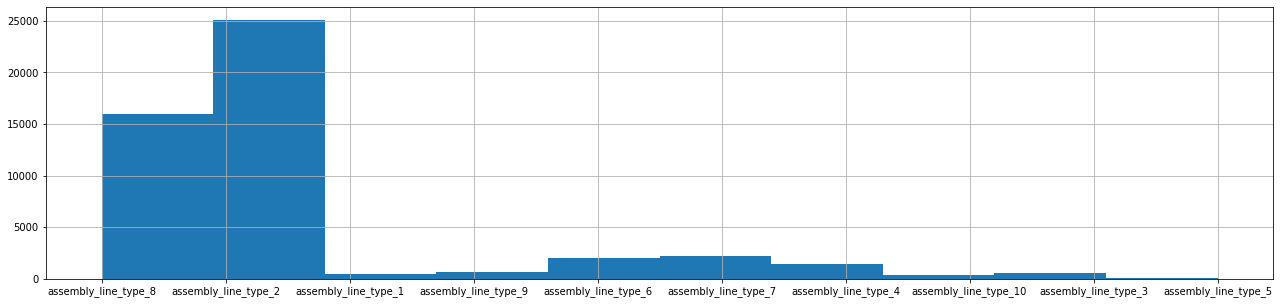

In [19]:
data['assembly_line_type'].hist(figsize=(22,5))

Observation: Age is clearly a right skewed one.

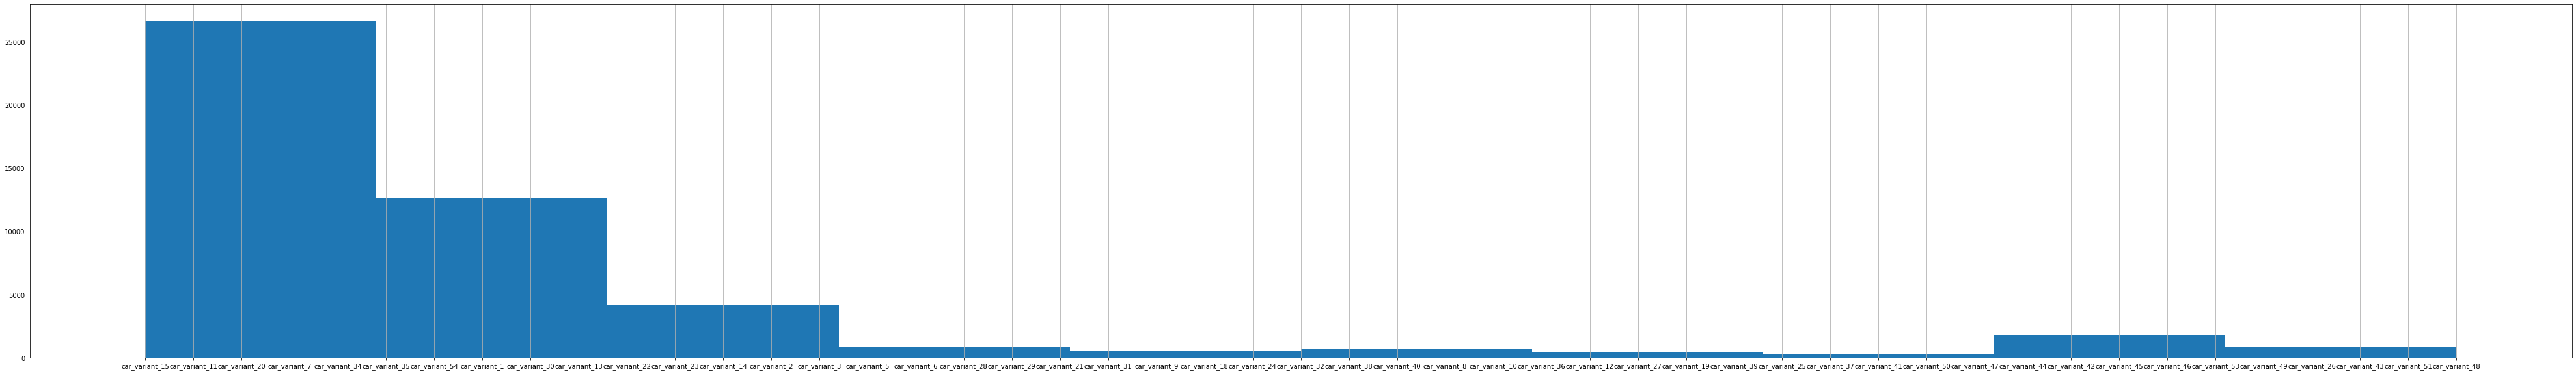

In [20]:
data['car_variant'].hist(figsize=(70,10))

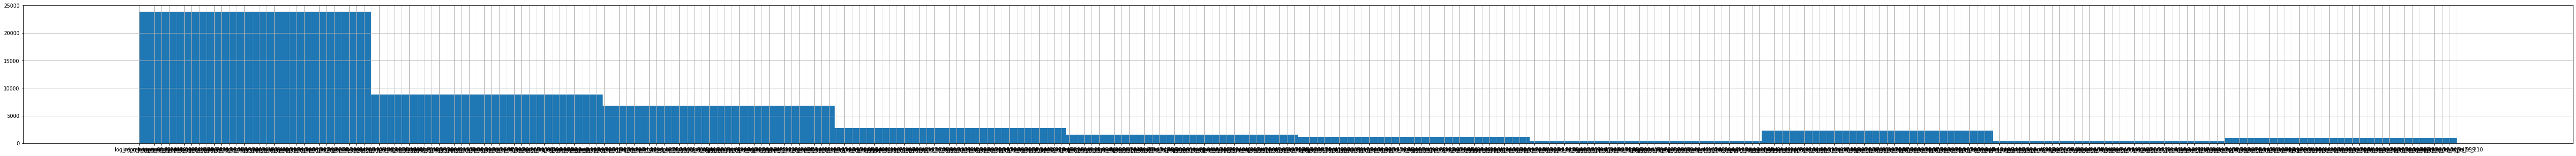

In [21]:
data['log_report_type'].hist(figsize=(90,5))

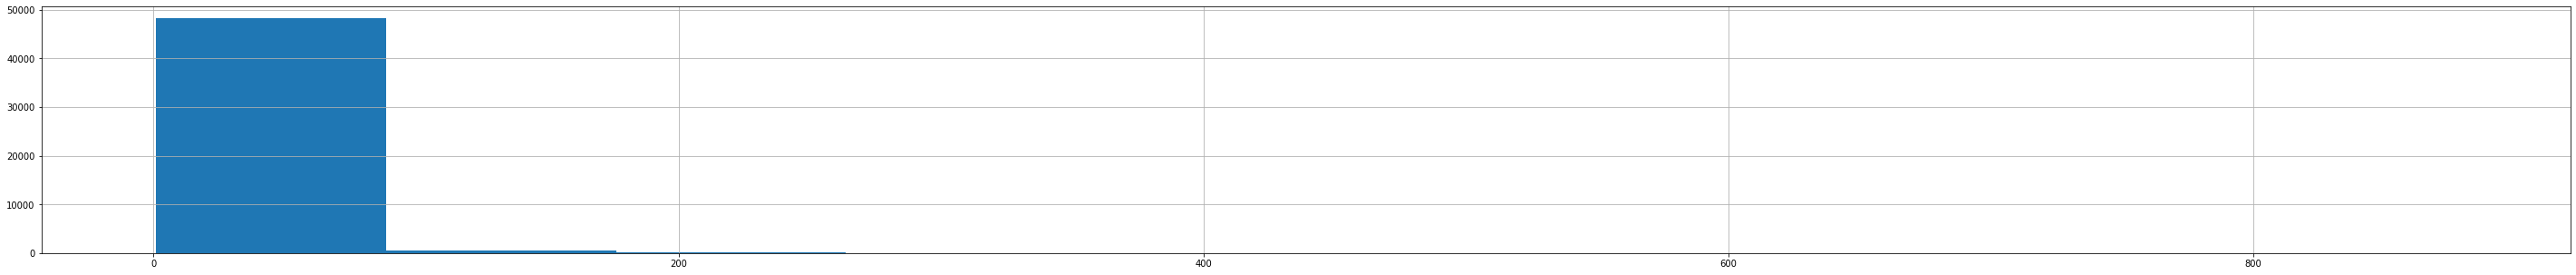

In [22]:
data['volume'].hist(figsize=(50, 5));

In [23]:
def barplot(column,data):
    bar_plot1 = sns.countplot(x=column, data=data)
    
    total = len(data[column])
    for p in bar_plot1.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        height = p.get_height()
        bar_plot1.text(p.get_x()+ p.get_width()/2, height + 400, percentage, ha="center")

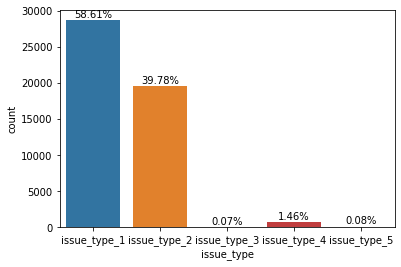

In [24]:
barplot("issue_type",data)

## **Checking  target feature distribution**

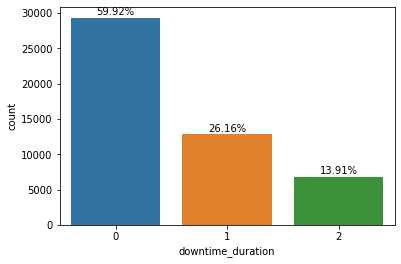

In [25]:
barplot("downtime_duration",data)

In [26]:
cat_cols = data.select_dtypes('category').columns
cat_cols

Index(['assembly_line_type', 'car_variant', 'issue_type', 'log_report_type',
       'factory_number', 'downtime_duration'],
      dtype='object')

In [27]:
def find_chi2_independence(cat_col, target, data, alpha=0.05):
    data = data[[target, cat_col]]
    tab = sm.stats.Table.from_data(data)
    tab = tab.table_orig.to_numpy()
    print(f"---------------{target} Vs {cat_col} Chi Square Test of Independence -------------------")
    print(f"\n Contingency table :\n")
    print(tab)
    
    stat, p, dof, expected = chi2_contingency(tab)
    print(f"\n Expected table :\n")
    print(expected)
    
    print(f"The p value returned = {p} and degrees of freedom returned = {dof}")
    
    # interpret p-value
    print('significance(alpha) = %.3f' % (alpha))

    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)') 

In [28]:
for col in cat_cols:
    find_chi2_independence(col, 'downtime_duration', data, alpha=0.05)

---------------downtime_duration Vs assembly_line_type Chi Square Test of Independence -------------------

 Contingency table :

[[  172   201 19003   149   703     0   692  1052  7096   279]
 [   56   108  4615   286   402     0   848   879  5352   266]
 [  253    70  1456   126   364   110   498   306  3533    98]]

 Expected table :

[[  288.23856002   227.11520634 15025.55853225   336.17844527
    880.29614277    65.91734221  1221.26857656  1340.5190411
   9576.59132583   385.31682764]
 [  125.83611378    99.15153248  6559.69795602   146.76519715
    384.31029343    28.77748964   533.16839891   585.2294938
   4180.84601719   168.21750761]
 [   66.9253262     52.73326118  3488.74351173    78.05635758
    204.3935638     15.30516815   283.56302452   311.25146509
   2223.56265697    89.46566475]]
The p value returned = 0.0 and degrees of freedom returned = 18
significance(alpha) = 0.050
Dependent (reject H0)
---------------downtime_duration Vs car_variant Chi Square Test of Independe

**Observation:**

assembly_line_type, car_variant, issue_type, log_report_type, factory_number,  attributes tend to influence the target


## **Feature Engineering**

In [29]:
data['downtime_duration'].value_counts()

0    29347
1    12812
2     6814
Name: downtime_duration, dtype: int64

# **Split the data into train and test**

In [30]:
y=data["downtime_duration"]
X=data.drop('downtime_duration', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20,random_state=123, stratify=y)

In [31]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(39178, 6)
(9795, 6)
(39178,)
(9795,)


## **Split the attributes into numerical and categorical types**

In [32]:
num_attr=X_train.select_dtypes(['int64']).columns
num_attr

Index(['volume'], dtype='object')

In [33]:
cat_attr = X_train.select_dtypes('category').columns
cat_attr

Index(['assembly_line_type', 'car_variant', 'issue_type', 'log_report_type',
       'factory_number'],
      dtype='object')

# **Preparation for Model buillding**

## Imputing missing values with median for numerical attributes

In [34]:
imputer = SimpleImputer(strategy='median')

imputer = imputer.fit(X_train[num_attr])

X_train[num_attr] = imputer.transform(X_train[num_attr])
X_val[num_attr] = imputer.transform(X_val[num_attr])

In [35]:
print(X_train.isnull().sum())
print(X_val.isnull().sum())

assembly_line_type    0
car_variant           0
issue_type            0
log_report_type       0
volume                0
factory_number        0
dtype: int64
assembly_line_type    0
car_variant           0
issue_type            0
log_report_type       0
volume                0
factory_number        0
dtype: int64


## **Imputing missing values with mode for categorical attributes**

In [36]:
imputer = SimpleImputer(strategy='most_frequent')

imputer = imputer.fit(X_train[cat_attr])

X_train[cat_attr] = imputer.transform(X_train[cat_attr])
X_val[cat_attr] = imputer.transform(X_val[cat_attr])

In [37]:
# DataFrameMapper, a class for mapping pandas data frame columns to different sklearn transformations
mapper = DataFrameMapper(
  [([continuous_col], StandardScaler()) for continuous_col in num_attr] +
  [([categorical_col], OneHotEncoder(handle_unknown="ignore", sparse=False)) for categorical_col in cat_attr]
, df_out=True)

In [38]:
print(type(mapper))

<class 'sklearn_pandas.dataframe_mapper.DataFrameMapper'>


In [39]:
mapper.fit(X_train)

DataFrameMapper(default=False, df_out=True,
                features=[(['volume'],
                           StandardScaler(copy=True, with_mean=True,
                                          with_std=True)),
                          (['assembly_line_type'],
                           OneHotEncoder(categories='auto', drop=None,
                                         dtype=<class 'numpy.float64'>,
                                         handle_unknown='ignore',
                                         sparse=False)),
                          (['car_variant'],
                           OneHotEncoder(categories='auto', drop=None,
                                         dtype=<class 'numpy.float64'>,
                                         handle_u...
                                         dtype=<class 'numpy.float64'>,
                                         handle_unknown='ignore',
                                         sparse=False)),
                          (['log_repo

In [40]:
X_train_final = mapper.transform(X_train)
X_val_final = mapper.transform(X_val)

In [41]:
X_train_final.head()

,volume,assembly_line_type_x0_assembly_line_type_1,assembly_line_type_x0_assembly_line_type_10,assembly_line_type_x0_assembly_line_type_2,assembly_line_type_x0_assembly_line_type_3,assembly_line_type_x0_assembly_line_type_4,assembly_line_type_x0_assembly_line_type_5,assembly_line_type_x0_assembly_line_type_6,assembly_line_type_x0_assembly_line_type_7,assembly_line_type_x0_assembly_line_type_8,assembly_line_type_x0_assembly_line_type_9,car_variant_x0_car_variant_1,car_variant_x0_car_variant_10,car_variant_x0_car_variant_11,car_variant_x0_car_variant_12,car_variant_x0_car_variant_13,car_variant_x0_car_variant_14,car_variant_x0_car_variant_15,car_variant_x0_car_variant_18,car_variant_x0_car_variant_19,car_variant_x0_car_variant_2,car_variant_x0_car_variant_20,car_variant_x0_car_variant_21,car_variant_x0_car_variant_22,car_variant_x0_car_variant_23,car_variant_x0_car_variant_24,car_variant_x0_car_variant_25,car_variant_x0_car_variant_26,car_variant_x0_car_variant_27,car_variant_x0_car_variant_28,car_variant_x0_car_variant_29,car_variant_x0_car_variant_3,car_variant_x0_car_variant_30,car_variant_x0_car_variant_31,car_variant_x0_car_variant_32,car_variant_x0_car_variant_34,car_variant_x0_car_variant_35,car_variant_x0_car_variant_36,car_variant_x0_car_variant_37,car_variant_x0_car_variant_38,...,factory_number_x0_factory_number_949,factory_number_x0_factory_number_95,factory_number_x0_factory_number_950,factory_number_x0_factory_number_951,factory_number_x0_factory_number_953,factory_number_x0_factory_number_955,factory_number_x0_factory_number_956,factory_number_x0_factory_number_957,factory_number_x0_factory_number_958,factory_number_x0_factory_number_960,factory_number_x0_factory_number_961,factory_number_x0_factory_number_962,factory_number_x0_factory_number_963,factory_number_x0_factory_number_964,factory_number_x0_factory_number_967,factory_number_x0_factory_number_968,factory_number_x0_factory_number_97,factory_number_x0_factory_number_971,factory_number_x0_factory_number_972,factory_number_x0_factory_number_973,factory_number_x0_factory_number_974,factory_number_x0_factory_number_975,factory_number_x0_factory_number_976,factory_number_x0_factory_number_977,factory_number_x0_factory_number_978,factory_number_x0_factory_number_979,factory_number_x0_factory_number_980,factory_number_x0_factory_number_981,factory_number_x0_factory_number_983,factory_number_x0_factory_number_984,factory_number_x0_factory_number_987,factory_number_x0_factory_number_989,factory_number_x0_factory_number_99,factory_number_x0_factory_number_990,factory_number_x0_factory_number_991,factory_number_x0_factory_number_994,factory_number_x0_factory_number_995,factory_number_x0_factory_number_996,factory_number_x0_factory_number_998,factory_number_x0_factory_number_999
15236,-0.322948,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13733,-0.322948,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25348,0.778364,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32692,-0.322948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [42]:
X_val_final.head()

,volume,assembly_line_type_x0_assembly_line_type_1,assembly_line_type_x0_assembly_line_type_10,assembly_line_type_x0_assembly_line_type_2,assembly_line_type_x0_assembly_line_type_3,assembly_line_type_x0_assembly_line_type_4,assembly_line_type_x0_assembly_line_type_5,assembly_line_type_x0_assembly_line_type_6,assembly_line_type_x0_assembly_line_type_7,assembly_line_type_x0_assembly_line_type_8,assembly_line_type_x0_assembly_line_type_9,car_variant_x0_car_variant_1,car_variant_x0_car_variant_10,car_variant_x0_car_variant_11,car_variant_x0_car_variant_12,car_variant_x0_car_variant_13,car_variant_x0_car_variant_14,car_variant_x0_car_variant_15,car_variant_x0_car_variant_18,car_variant_x0_car_variant_19,car_variant_x0_car_variant_2,car_variant_x0_car_variant_20,car_variant_x0_car_variant_21,car_variant_x0_car_variant_22,car_variant_x0_car_variant_23,car_variant_x0_car_variant_24,car_variant_x0_car_variant_25,car_variant_x0_car_variant_26,car_variant_x0_car_variant_27,car_variant_x0_car_variant_28,car_variant_x0_car_variant_29,car_variant_x0_car_variant_3,car_variant_x0_car_variant_30,car_variant_x0_car_variant_31,car_variant_x0_car_variant_32,car_variant_x0_car_variant_34,car_variant_x0_car_variant_35,car_variant_x0_car_variant_36,car_variant_x0_car_variant_37,car_variant_x0_car_variant_38,...,factory_number_x0_factory_number_949,factory_number_x0_factory_number_95,factory_number_x0_factory_number_950,factory_number_x0_factory_number_951,factory_number_x0_factory_number_953,factory_number_x0_factory_number_955,factory_number_x0_factory_number_956,factory_number_x0_factory_number_957,factory_number_x0_factory_number_958,factory_number_x0_factory_number_960,factory_number_x0_factory_number_961,factory_number_x0_factory_number_962,factory_number_x0_factory_number_963,factory_number_x0_factory_number_964,factory_number_x0_factory_number_967,factory_number_x0_factory_number_968,factory_number_x0_factory_number_97,factory_number_x0_factory_number_971,factory_number_x0_factory_number_972,factory_number_x0_factory_number_973,factory_number_x0_factory_number_974,factory_number_x0_factory_number_975,factory_number_x0_factory_number_976,factory_number_x0_factory_number_977,factory_number_x0_factory_number_978,factory_number_x0_factory_number_979,factory_number_x0_factory_number_980,factory_number_x0_factory_number_981,factory_number_x0_factory_number_983,factory_number_x0_factory_number_984,factory_number_x0_factory_number_987,factory_number_x0_factory_number_989,factory_number_x0_factory_number_99,factory_number_x0_factory_number_990,factory_number_x0_factory_number_991,factory_number_x0_factory_number_994,factory_number_x0_factory_number_995,factory_number_x0_factory_number_996,factory_number_x0_factory_number_998,factory_number_x0_factory_number_999
35282,-0.111158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46531,-0.068799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41404,-0.322948,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35824,-0.322948,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### **Defining Error Metrics**

In [43]:
def get_CR_CM(train_actual,train_predicted,test_actual,test_predicted):
    print('''
         ========================================
           CLASSIFICATION REPORT FOR TRAIN DATA
         ========================================
        ''')
    print(classification_report(train_actual, train_predicted, digits=4))

    print('''
             =============================================
               CLASSIFICATION REPORT FOR VALIDATION DATA
             =============================================
            ''')
    print(classification_report(test_actual, test_predicted, digits=4))

    print('''
             ========================================
               Confusion Matrix FOR TRAIN DATA
             ========================================
            ''')
    print(confusion_matrix(train_actual, train_predicted))

    print('''
             =============================================
               Confusion matrix FOR VALIDATION DATA
             =============================================
            ''')
    print(confusion_matrix(test_actual, test_predicted))

In [44]:
scores = pd.DataFrame(columns=['Model','Train_Accuracy','Train_Recall','Train_Precision','Train_F1_Score','Test_Accuracy','Test_Recall','Test_Precision','Test_F1_Score'])

def get_metrics(train_actual,train_predicted,test_actual,test_predicted,model_description,dataframe):
    get_CR_CM(train_actual,train_predicted,test_actual,test_predicted)
    train_accuracy = accuracy_score(train_actual,train_predicted)
    train_recall   = recall_score(train_actual,train_predicted,average='micro')
    train_precision= precision_score(train_actual,train_predicted,average='micro')
    train_f1score  = f1_score(train_actual,train_predicted,average='micro')
    test_accuracy = accuracy_score(test_actual,test_predicted)
    test_recall   = recall_score(test_actual,test_predicted,average='micro')
    test_precision= precision_score(test_actual,test_predicted,average='micro')
    test_f1score  = f1_score(test_actual,test_predicted,average='micro')
    dataframe = dataframe.append(pd.Series([model_description, train_accuracy,train_recall,train_precision,train_f1score,
                                            test_accuracy,test_recall,test_precision,test_f1score],
                                           index=scores.columns ), ignore_index=True)
    return(dataframe)

# **MODEL BUILDING**

**1. Logistic Regression**

In [45]:
log_mod = LogisticRegression(random_state=123)

In [46]:
log_mod.fit(X_train_final, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
y_pred_train = log_mod.predict(X_train_final)
y_pred_val = log_mod.predict(X_val_final)

In [48]:
scores = get_metrics(y_train,y_pred_train,y_val,y_pred_val,"LogisticRegression",scores)
scores


           CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.8575    0.8735    0.8654     23477
           1     0.7060    0.6559    0.6800     10250
           2     0.6833    0.7193    0.7009      5451

    accuracy                         0.7951     39178
   macro avg     0.7489    0.7496    0.7488     39178
weighted avg     0.7936    0.7951    0.7940     39178


               CLASSIFICATION REPORT FOR VALIDATION DATA
            
              precision    recall  f1-score   support

           0     0.8412    0.8705    0.8556      5870
           1     0.7012    0.6237    0.6602      2562
           2     0.6655    0.7036    0.6840      1363

    accuracy                         0.7827      9795
   macro avg     0.7359    0.7326    0.7333      9795
weighted avg     0.7801    0.7827    0.7806      9795


               Confusion Matrix FOR TRAIN DATA
            
[[20508  2040   929]
 [ 2639  6723   888]
 [  77

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.79514,0.79514,0.79514,0.79514,0.782746,0.782746,0.782746,0.782746


### **2. Decision Tree Classifier**

In [49]:
# Create Decision Tree classifer object
clf_dt = DecisionTreeClassifier(random_state=123)

# Train Decision Tree Classifer
clf_dt.fit(X_train_final,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [50]:
y_pred_train = clf_dt.predict(X_train_final)
y_pred_val = clf_dt.predict(X_val_final)

In [51]:
scores = get_metrics(y_train,y_pred_train,y_val,y_pred_val,"DecisionTree",scores)
scores


           CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.9386    0.9885    0.9629     23477
           1     0.9409    0.8792    0.9090     10250
           2     0.9750    0.8721    0.9207      5451

    accuracy                         0.9437     39178
   macro avg     0.9515    0.9133    0.9309     39178
weighted avg     0.9443    0.9437    0.9429     39178


               CLASSIFICATION REPORT FOR VALIDATION DATA
            
              precision    recall  f1-score   support

           0     0.8737    0.9078    0.8905      5870
           1     0.7613    0.7307    0.7457      2562
           2     0.8108    0.7359    0.7715      1363

    accuracy                         0.8376      9795
   macro avg     0.8153    0.7915    0.8026      9795
weighted avg     0.8356    0.8376    0.8360      9795


               Confusion Matrix FOR TRAIN DATA
            
[[23206   219    52]
 [ 1168  9012    70]
 [  35

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.795140,0.795140,0.795140,0.795140,0.782746,0.782746,0.782746,0.782746
1,DecisionTree,0.943693,0.943693,0.943693,0.943693,0.837570,0.837570,0.837570,0.837570


### 3. Adaboost Classifier

In [96]:
clf_ada = AdaBoostClassifier(DecisionTreeClassifier(criterion="gini",class_weight='balanced'),n_estimators=100,learning_rate = 0.4,random_state=123)
clf_ada.fit(X_train_final, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                 

In [97]:
y_pred_train = clf_ada.predict(X_train_final)
y_pred_val = clf_ada.predict(X_val_final)

In [98]:
scores = get_metrics(y_train,y_pred_train,y_val,y_pred_val,"Adaboost",scores)
scores


           CLASSIFICATION REPORT FOR TRAIN DATA
        
              precision    recall  f1-score   support

           0     0.9897    0.9267    0.9572     23477
           1     0.8663    0.9523    0.9073     10250
           2     0.8740    0.9507    0.9107      5451

    accuracy                         0.9367     39178
   macro avg     0.9100    0.9432    0.9251     39178
weighted avg     0.9413    0.9367    0.9377     39178


               CLASSIFICATION REPORT FOR VALIDATION DATA
            
              precision    recall  f1-score   support

           0     0.8817    0.8683    0.8749      5870
           1     0.7160    0.7123    0.7141      2562
           2     0.7078    0.7608    0.7334      1363

    accuracy                         0.8126      9795
   macro avg     0.7685    0.7805    0.7742      9795
weighted avg     0.8141    0.8126    0.8132      9795


               Confusion Matrix FOR TRAIN DATA
            
[[21756  1300   421]
 [  163  9761   326]
 [   6

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.795140,0.795140,0.795140,0.795140,0.782746,0.782746,0.782746,0.782746
1,DecisionTree,0.943693,0.943693,0.943693,0.943693,0.837570,0.837570,0.837570,0.837570
2,Adaboost,0.936725,0.936725,0.936725,0.936725,0.812557,0.812557,0.812557,0.812557


### **4. Decision Tree with Grid-Search CV - Hyper-parameter Tuning**

In [99]:
# set of parameters to test
param_grid = {"class_weight":['balanced', None],
              "criterion": ["gini", "entropy"],
              "max_depth": [3, 5, 6],
              "min_samples_leaf": [2, 5, 10],
               "max_leaf_nodes": [None, 5, 10, 20]
              }

In [103]:
dt = DecisionTreeClassifier(random_state=123)
clf_dt_grid = GridSearchCV(dt, param_grid,cv=5)
clf_dt_grid.fit(X_train_final, y_train)

KeyboardInterrupt: ignored

In [102]:
clf_dt_grid.best_params_

AttributeError: ignored

In [ ]:
y_pred_train = clf_dt_grid.predict(X_train_final)
y_pred_val = clf_dt_grid.predict(X_val_final)

In [ ]:
scores = get_metrics(y_train,y_pred_train,y_val,y_pred_val,"DecisionTree_BestParameters",scores)
scores

### 5. Decision Tree with RandomizedSearchCV - Hyper-parameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

clf3_dt = DecisionTreeClassifier(random_state=123, class_weight='balanced') 

In [ ]:
max_leaf_nodes = np.random.normal(loc=5, scale=1, size=5).astype(int)
max_leaf_nodes[max_leaf_nodes <1] = 1
print(max_leaf_nodes)
max_depth = np.random.uniform(2,5,4).astype(int)
print(max_depth)
min_samples_split = np.random.uniform(2, 6, 5).astype(int)
print(min_samples_split)

In [ ]:
## Set Up Hyperparameter Distributions

# normally distributed max_leaf_nodes, with mean 5 stddev 1
max_leaf_nodes = np.random.normal(loc=5, scale=1, size=5).astype(int)

# uniform distribution from 2 to 5 
max_depth = np.random.uniform(2,5,4).astype(int)

# uniform distribution from 2 to 6
min_samples_split = np.random.uniform(2, 6, 5).astype(int)

model_params = {
    'max_depth': list(max_depth),
    'max_leaf_nodes': list(max_leaf_nodes),
    'min_samples_split': list(min_samples_split)
}

In [ ]:
clf_random = RandomizedSearchCV(estimator=clf3_dt, param_distributions=model_params, n_iter=600, cv=5, scoring='recall', n_jobs=-1)
clf_random.fit(X_train_final, y_train)

In [ ]:
print(clf_random.best_score_, clf_random.best_params_)

In [ ]:
clf_dt_random = clf_random.best_estimator_
print(clf_dt_random)

In [ ]:
y_pred_train = clf_dt_random.predict(X_train_final)
y_pred_val = clf_dt_random.predict(X_val_final)

In [ ]:
scores = get_metrics(y_train,y_pred_train,y_val,y_pred_val,"DecisionTree_RandomizedSearch",scores)
scores

### **6. Adaboost Classifier with Grid Search CV**

In [ ]:
# GridSearchCV
param_grid = {'n_estimators' : [100, 200, 300],
              'learning_rate' : [0.2, 0.3, 0.4]}

clf_grid_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier()), param_grid, scoring='recall',n_jobs=-1)

In [ ]:
clf_grid_ada.fit(X_train_final, y_train)

In [ ]:
best_ada_model = clf_grid_ada.best_estimator_
print(best_ada_model)
print (clf_grid_ada.best_score_, clf_grid_ada.best_params_) 

In [ ]:
y_pred_train = best_ada_model.predict(X_train_final)
y_pred_val = best_ada_model.predict(X_val_final)

In [ ]:
scores = get_metrics(y_train,y_pred_train,y_val,y_pred_val,"Adaboost_BestParameters",scores)
scores

In [81]:
from google.colab import files

In [82]:
scores.to_csv("/mith_Solution1.csv")
scores.to_csv("mith_Solution1.csv")
files.download("mith_Solution1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Observations:**


1.   Is there no overfitting or underfitting problem in this problem statement
2.   Which assembly line types are suspect of long downtime durations? - assembly_line_type_2



In [63]:

from google.colab import data_table
data_table.DataTable(scores)

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,LogisticRegression,0.795140,0.795140,0.795140,0.795140,0.782746,0.782746,0.782746,0.782746
1,DecisionTree,0.943693,0.943693,0.943693,0.943693,0.837570,0.837570,0.837570,0.837570
